## IRIS Task

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

### Helper functions for handling data

In [2]:
name_classes = np.array(["Setosa", "Versicolor", "Virginica"])
name_features = np.array(["Sepal length", "Sepal width", "Petal length", "Petal width"])

def load_data() -> np.array:
    """Load the data from all three classes into on 3D numpy array"""
    class_1_data = np.loadtxt('iris_data/class_1', dtype=np.float32, delimiter=',')  # Setosa
    class_2_data = np.loadtxt('iris_data/class_2', dtype=np.float32, delimiter=',')  # Versicolor
    class_3_data = np.loadtxt('iris_data/class_3', dtype=np.float32, delimiter=',')  # Virginica
    data = np.stack((class_1_data, class_2_data, class_3_data))
    return data

def split_data(data, train_size) -> tuple[np.array, np.array]:
    """Split the data from each class into two chucnks, the first with train_size
    data points. Combine the first chuncks from each class togheter, same for second chunk"""
    splitted_data = np.split(data, [train_size], axis=1)   # Split data from each class
    train_data = np.concatenate(splitted_data[0], axis=0)  # Combine training chunck from each class
    test_data = np.concatenate(splitted_data[1], axis=0)   # Combine test chunck from each class
    return (train_data, test_data)

def extend_data(data) -> np.array:
    """To simplify calculations we extend each sample with a 1 to add the
    constant term w0"""
    return np.concatenate((data, np.ones((data.shape[0], 1))), axis=1)

def generate_labels(train_size) -> tuple[np.array, np.array]:
    """Generate labels for both the training set and test set"""
    T_train = np.concatenate((
        np.tile([1,0,0], (train_size, 1)),
        np.tile([0,1,0], (train_size, 1)),
        np.tile([0,0,1], (train_size, 1)))
    )

    T_test = np.concatenate((
        np.tile([1,0,0], (50 - train_size, 1)),
        np.tile([0,1,0], (50 - train_size, 1)),
        np.tile([0,0,1], (50 - train_size, 1)))
    )

    return T_train, T_test

### Helper functions for training of linear classifier

In [3]:
def g(x, W):
    """Produce a value 0-1 for a given feature vector. Equation 20 on vector form classification compendium"""
    zk = np.matmul(W, x)
    gk = 1 / (1 + np.exp(-zk))
    return gk

def MSE(X, T, W):
    """Calculate the MSE, taken from equation 19 in classification compendium"""
    mseSum = 0
    for i in range(np.size(X, 0)):
        xk = X[i,:]
        tk = T[i,:]
        gk = g(xk, W)
        
        mseSum += (1/2)* np.linalg.norm((gk - tk), ord=2)
    
    return mseSum

def grad_MSE(X, T, W):
    """Gradient of MSE, taken from equation 22"""
    gradMSESum = np.zeros(W.shape)
    
    for i in range(np.size(X, 0)):
        xk = X[i,:]
        tk = T[i,:]
        gk = g(xk, W)
        
        a = np.multiply((gk - tk), gk)
        b = np.multiply(a, np.ones(3).T - gk)

        gradMSESum += np.outer(b, xk)

    return gradMSESum

def gradient_descent(alpha, X, T, max_iterations=1e3):
    """Perform gradient descent for a fixed amount of iterations"""
    W = np.zeros((3, X.shape[1])) 
    iteration = 0
    mse_iter = np.zeros(int(max_iterations))
    while iteration < max_iterations:
        W = W - alpha * grad_MSE(X, T, W)
        mse_iter[iteration] = MSE(X, T, W)
        iteration += 1
        # print(f"Iteration: {iterations:06}, MSE: {MSE(X, T, W):.2f}, |∇MSE|: {np.linalg.norm(grad_MSE(X, T, W), ord='fro'):.4f}")

    return (W, mse_iter)

### Helper functions for verification of model

In [4]:

def generate_conf_matrix(X, T, W):
    """Generate a confusion matrix for extended data X with labels T when 
    using a linear model with extend matrix W"""
    # 0-axis / y-axis: true class
    # 1-axis / x-axis: predicted class
    conf_matrix = np.zeros((3,3), dtype=int)

    for i in range(np.size(X, 0)):
        x = X[i, :]
        t = T[i, :]
        
        true_class = np.argmax(t)
        predicted_class = np.argmax(g(x, W))
        conf_matrix[true_class][predicted_class] += 1
    
    return conf_matrix

def calculate_performances(conf_matrix):
    """Calculate the precision, recall and accuracy"""
    # Precision: correctly classified as class i / all classified as class i
    precision = np.diag(conf_matrix) / np.sum(conf_matrix, axis=0)
    # Recall: correctly classified as class i / all true class i
    recall = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)
    # Accuracy: correctly classified / all samples
    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
    return precision, recall, accuracy


def generate_conf_matrix_figure(conf_matrix, title):
    """Create a plt.Figure representation of the confusion matrix"""
    confusion_fig = plt.figure(figsize = (10,7))
    confusion_fig = sn.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    
    _, _, accuracy = calculate_performances(conf_matrix)
    confusion_fig.set_title(f"{title}. Accuracy: {accuracy:.2%}")


    confusion_fig.set_ylabel("True class")
    confusion_fig.set_xlabel("Predicted class")
    
    confusion_fig.set_xticklabels(name_classes)
    confusion_fig.set_yticklabels(name_classes)
    return confusion_fig

### Test different step lengths

alpha: 0.1 MSE: 045.00 |∇MSE|: 0.0002
alpha: 0.01 MSE: 016.99 |∇MSE|: 3.3261
alpha: 0.001 MSE: 021.25 |∇MSE|: 1.4009
alpha: 0.0001 MSE: 027.16 |∇MSE|: 6.1463
alpha: 1e-05 MSE: 034.83 |∇MSE|: 15.8177


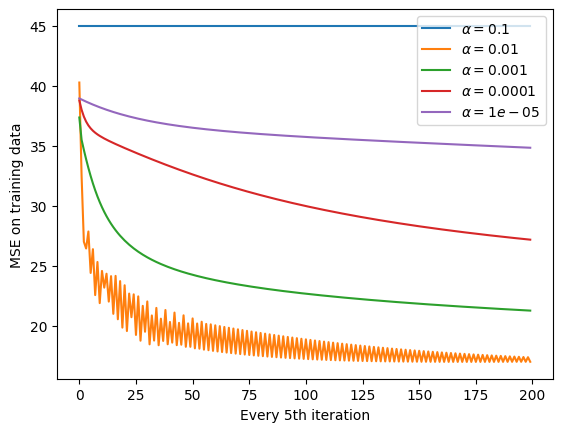

In [5]:
# Task 1.1a, 1.1b

train_size = 30

X_train_raw, X_test_raw = split_data(load_data(), train_size)
X_train, X_test = extend_data(X_train_raw), extend_data(X_test_raw)

alphas = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]

plt.figure()
for alpha in alphas:

    T_train, T_test = generate_labels(train_size)
    W, mse_iter = gradient_descent(alpha=alpha, X=X_train, T=T_train)
    print(f"alpha: {alpha} MSE: {MSE(X_train, T_train, W):06.2f} |∇MSE|: {np.linalg.norm(grad_MSE(X_train, T_train, W), ord='fro'):.4f}")
    plt.plot(mse_iter[::5], label=rf"$\alpha={alpha}$")

plt.xlabel("Every 5th iteration")
plt.ylabel("MSE on training data")
plt.legend()
plt.show()

In [6]:
def train_test_sequence(sequence_title, feat_remove=[], reverse_data=False):
    train_size = 30

    # Load data
    data = load_data()
    if reverse_data:
        data = np.flip(load_data(), axis=1)

    X_train_raw, X_test_raw = split_data(data, train_size)
    print(f"Shape of raw train data {X_train_raw.shape}")
    print(f"Shape of raw test data {X_test_raw.shape}")

    X_train, X_test = extend_data(X_train_raw), extend_data(X_test_raw)
    print(f"Shape of extended train data {X_train.shape}")
    print(f"Shape of extended test data {X_test.shape}")

    # Remove features
    if len(feat_remove):
        X_train = np.delete(X_train, obj=feat_remove, axis=1)
        X_test = np.delete(X_test, obj=feat_remove, axis=1)
        print(f"Shape of train data after removing features {X_train.shape}")
        print(f"Shape of test data after removing features{X_test.shape}")

    T_train, T_test = generate_labels(train_size)
    W, _ = gradient_descent(alpha=0.01, X=X_train, T=T_train)
    print(f"Final values on train set: MSE: {MSE(X_train, T_train, W):06.2f} |∇MSE|: {np.linalg.norm(grad_MSE(X_train, T_train, W), ord='fro'):.4f}")

    # Training set
    conf_matrix_train = generate_conf_matrix(X_train, T_train, W)
    fig_train = generate_conf_matrix_figure(conf_matrix_train, f"Training data. {sequence_title}")
    precision, recall, accuracy = calculate_performances(conf_matrix_train)
    print("\nTraining data")
    print(f"Accuracy: {accuracy:.2%}")
    for i, cls in enumerate(name_classes):
        print(f"{cls} precision: {precision[i]:.2%}, recall: {recall[i]:.2%}")
    plt.show()

    # Test set
    conf_matrix_test = generate_conf_matrix(X_test, T_test, W)
    fig_test = generate_conf_matrix_figure(conf_matrix_test, f"Test data. {sequence_title}")
    precision, recall, accuracy = calculate_performances(conf_matrix_test)
    print("\nTest data")
    print(f"Accuracy: {accuracy:.2%}")
    for i, cls in enumerate(name_classes):
        print(f"{cls} precision: {precision[i]:.2%}, recall: {recall[i]:.2%}")
    plt.show()

### Use the first 30 samples for training and the last  20 samples for testing

Shape of raw train data (90, 4)
Shape of raw test data (60, 4)
Shape of extended train data (90, 5)
Shape of extended test data (60, 5)
Final values on train set: MSE: 016.99 |∇MSE|: 3.3261

Training data
Accuracy: 96.67%
Setosa precision: 100.00%, recall: 100.00%
Versicolor precision: 96.55%, recall: 93.33%
Virginica precision: 93.55%, recall: 96.67%


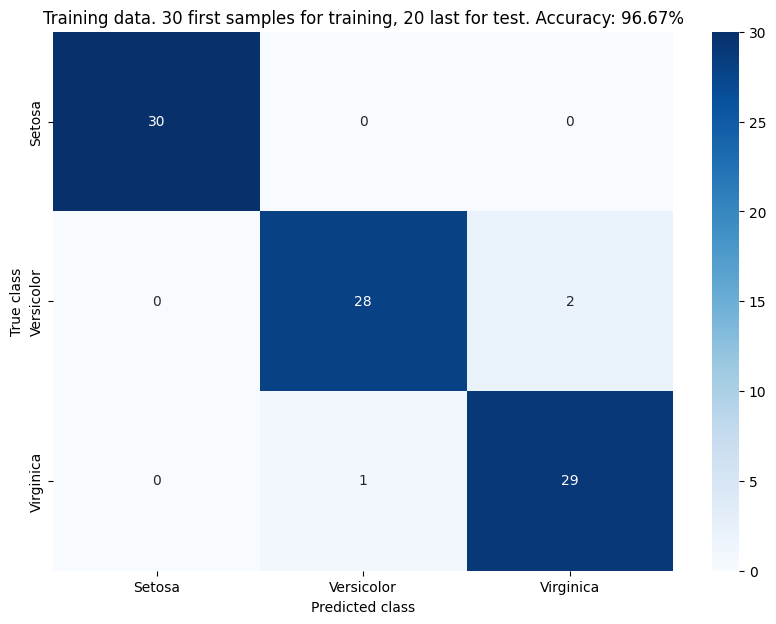


Test data
Accuracy: 95.00%
Setosa precision: 100.00%, recall: 100.00%
Versicolor precision: 100.00%, recall: 85.00%
Virginica precision: 86.96%, recall: 100.00%


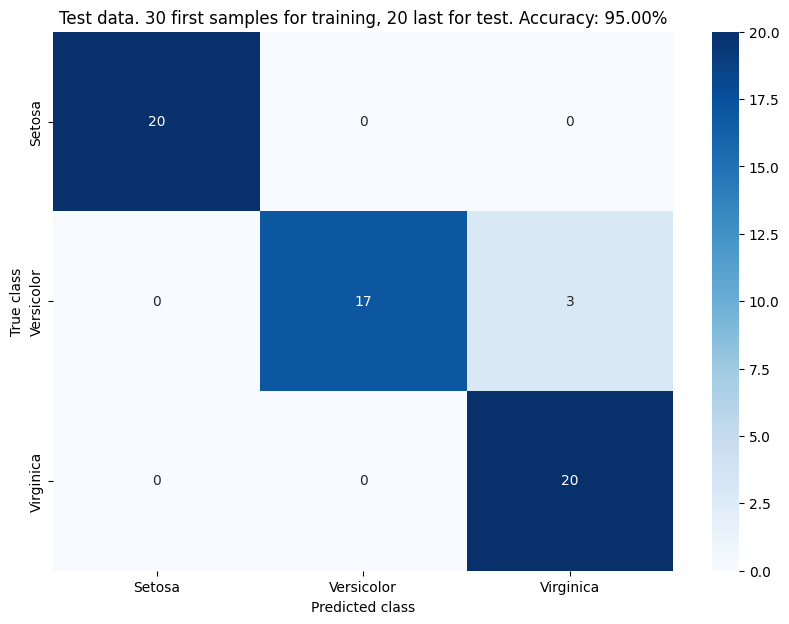

In [7]:
# Task 1.1a-c
train_test_sequence("30 first samples for training, 20 last for test",)

### Use the last 30 samples for training and the first 20 samples for testing

Shape of raw train data (90, 4)
Shape of raw test data (60, 4)
Shape of extended train data (90, 5)
Shape of extended test data (60, 5)
Final values on train set: MSE: 016.57 |∇MSE|: 10.9546

Training data
Accuracy: 93.33%
Setosa precision: 100.00%, recall: 100.00%
Versicolor precision: 96.15%, recall: 83.33%
Virginica precision: 85.29%, recall: 96.67%


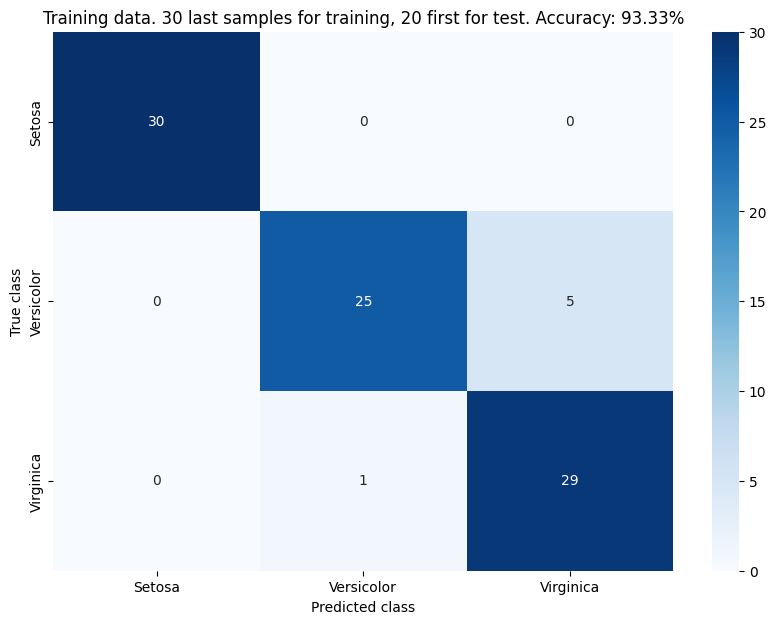


Test data
Accuracy: 98.33%
Setosa precision: 100.00%, recall: 100.00%
Versicolor precision: 100.00%, recall: 95.00%
Virginica precision: 95.24%, recall: 100.00%


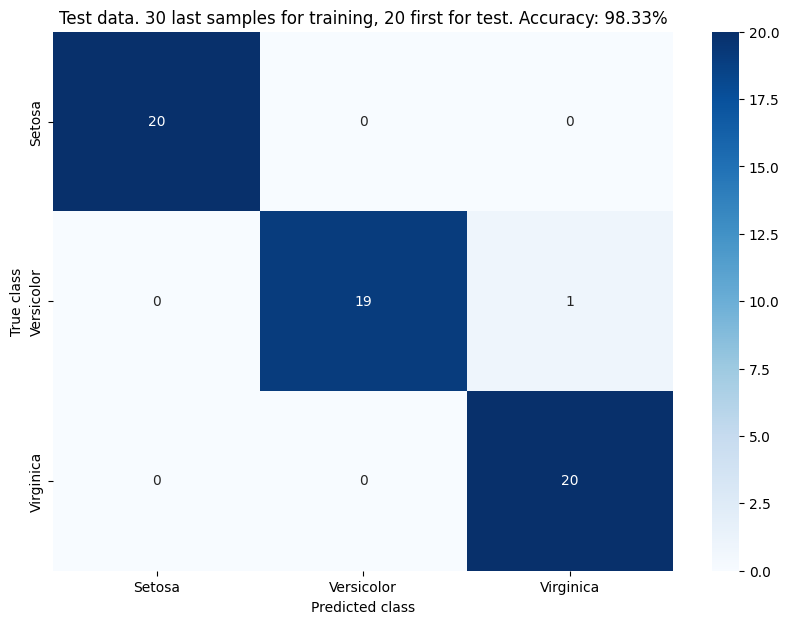

In [8]:
# Task 1.1d, training part
train_test_sequence("30 last samples for training, 20 first for test", reverse_data=True)

### Produce historgrams for each feature and class

Measure of overlap in each feature: [('Sepal length', 0.539999452521228), ('Sepal width', 0.7099992781222703), ('Petal length', 0.14333327541245056), ('Petal width', 0.16999998944501124)]


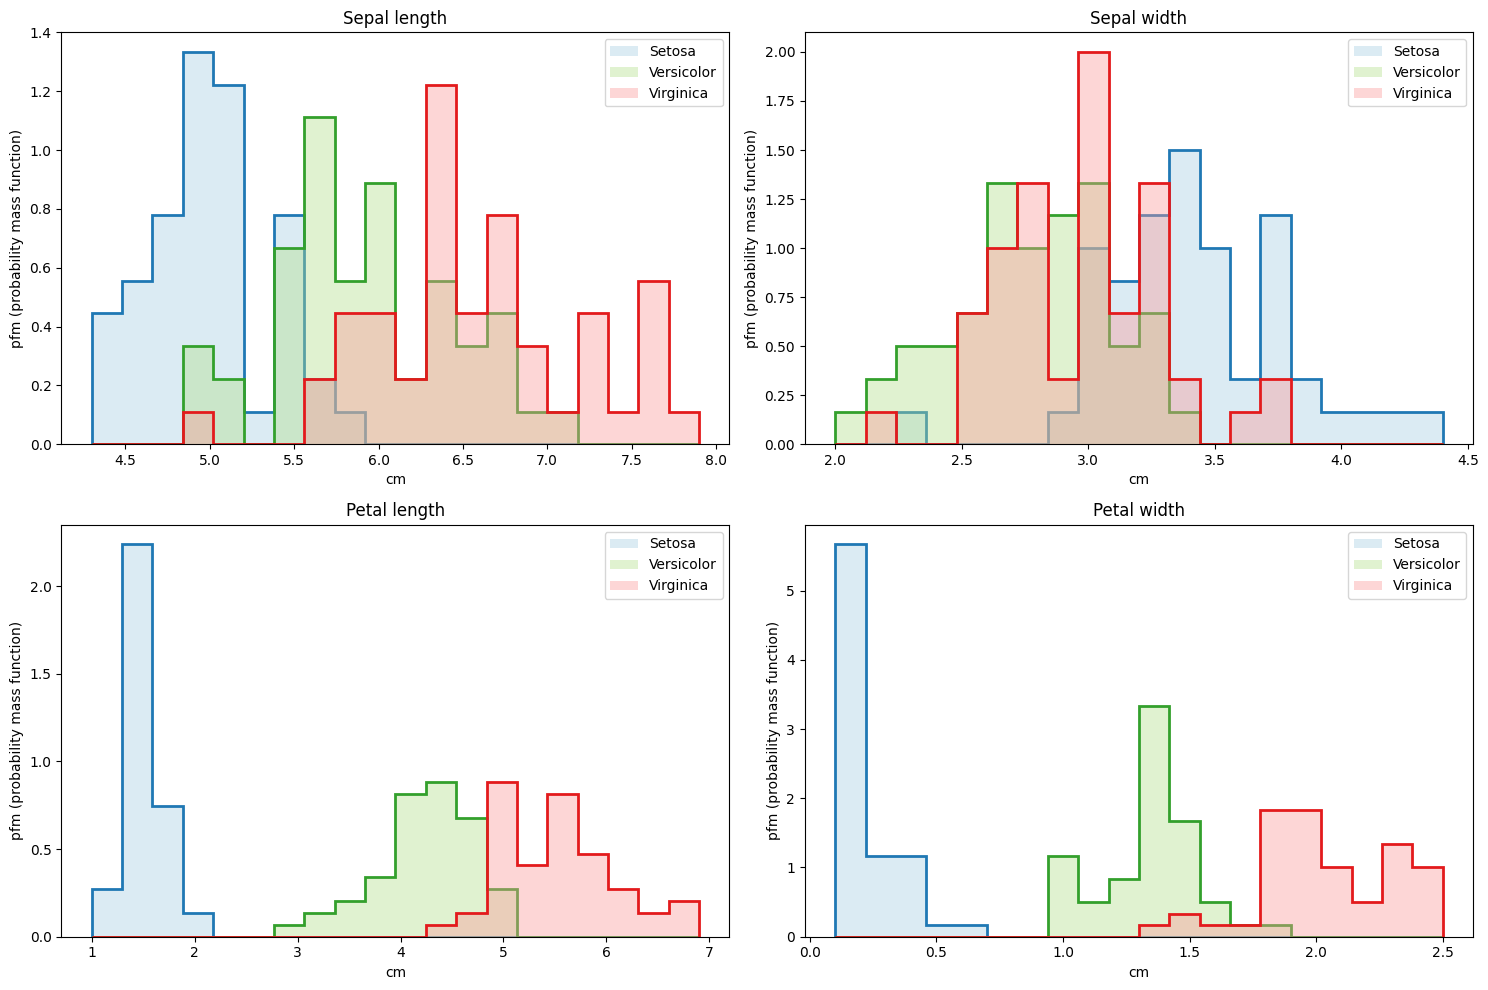

In [9]:
# Task 1.2a, data visualization
data = load_data()

hists = [[], [], []]

fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs = axs.flatten()

feats_min = np.min(data, axis=(0, 1))
feats_max = np.max(data, axis=(0, 1))

for feat in range(4):
    for cls in range(3):
        feature = data[cls][:, feat]
        counts, bins = np.histogram(feature, bins=20, range=(feats_min[feat], feats_max[feat]), density=True)
        hists[cls].append({"counts": counts, "bins": bins})

        axs[feat].stairs(counts, bins, label=name_classes[cls], fill=True, alpha=0.4, color=plt.cm.Paired.colors[2*cls])
        axs[feat].stairs(counts, bins, fill=False, linewidth=2, color=plt.cm.Paired.colors[2*cls+1])


    axs[feat].legend()
    axs[feat].set_title(name_features[feat])
    axs[feat].set_xlabel("cm")
    axs[feat].set_ylabel("pfm (probability mass function)")


fig.tight_layout()

# Not sure about this method for quantifying overlap

# Calculate thre overlap between the features. As all of the histograms for a feature class have the
# same bins and have been normalized, one can calculate the overlap between two histograms by summing
# the indexes where both of them are zero, multiplying the sum by the bin width and dividing by 2 (the total area)
# this can be done for all three combinations of the histograms for a feature to calculate the total overlap
overlap_feat = []
for feat in range(4):
    overlap_feat.append(0)
    for (i, j) in [(0,1), (0,2), (1, 2)]:
        mask_i_j = (hists[i][feat]["counts"] != 0) & (hists[j][feat]["counts"] != 0)
        overlap_i_j = np.sum(hists[i][feat]["counts"][mask_i_j] + hists[j][feat]["counts"][mask_i_j])
        overlap_feat[-1] += overlap_i_j*(hists[i][feat]["bins"][1]-hists[i][feat]["bins"][0])/2

    overlap_feat[-1] /= 3

print(f"Measure of overlap in each feature: {list(zip(name_features, overlap_feat))}")

### Remove sepal width

Shape of raw train data (90, 4)
Shape of raw test data (60, 4)
Shape of extended train data (90, 5)
Shape of extended test data (60, 5)
Shape of train data after removing features (90, 4)
Shape of test data after removing features(60, 4)
Final values on train set: MSE: 018.80 |∇MSE|: 14.0193

Training data
Accuracy: 92.22%
Setosa precision: 100.00%, recall: 100.00%
Versicolor precision: 100.00%, recall: 76.67%
Virginica precision: 81.08%, recall: 100.00%


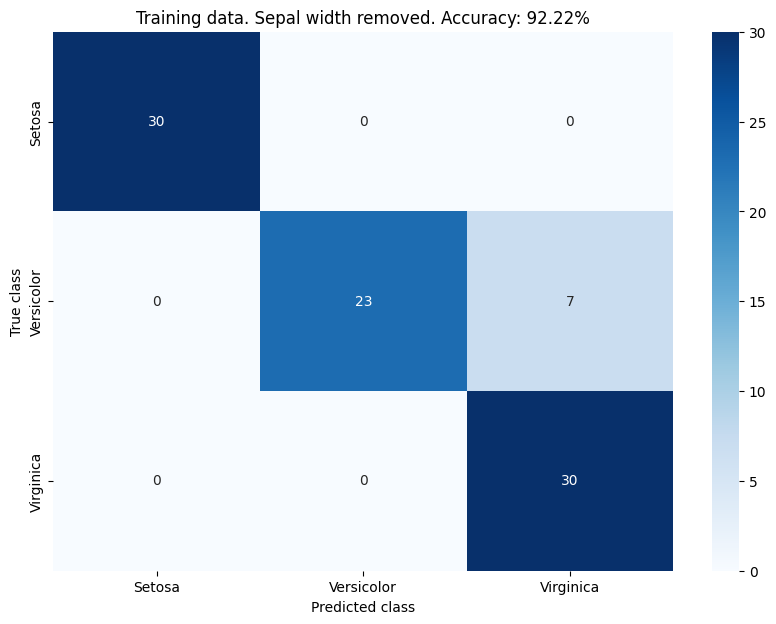


Test data
Accuracy: 95.00%
Setosa precision: 100.00%, recall: 100.00%
Versicolor precision: 100.00%, recall: 85.00%
Virginica precision: 86.96%, recall: 100.00%


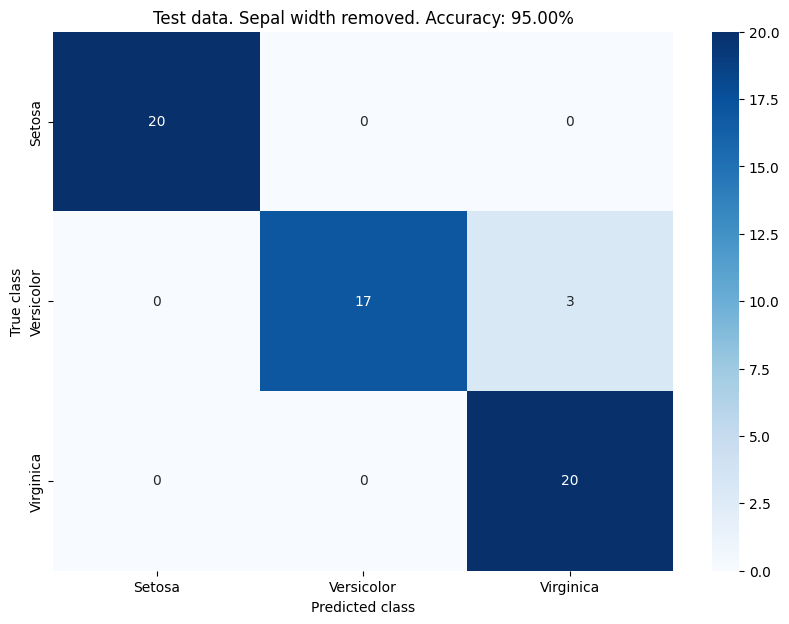

In [10]:
# Task 1.2a, remove sepal width
feat_remove_index = np.where(name_features == "Sepal width")[0]
train_test_sequence("Sepal width removed", feat_remove=feat_remove_index)

### Remove sepal width and sepal length

Shape of raw train data (90, 4)
Shape of raw test data (60, 4)
Shape of extended train data (90, 5)
Shape of extended test data (60, 5)
Shape of train data after removing features (90, 3)
Shape of test data after removing features(60, 3)
Final values on train set: MSE: 021.67 |∇MSE|: 0.3438

Training data
Accuracy: 93.33%
Setosa precision: 100.00%, recall: 100.00%
Versicolor precision: 92.86%, recall: 86.67%
Virginica precision: 87.50%, recall: 93.33%


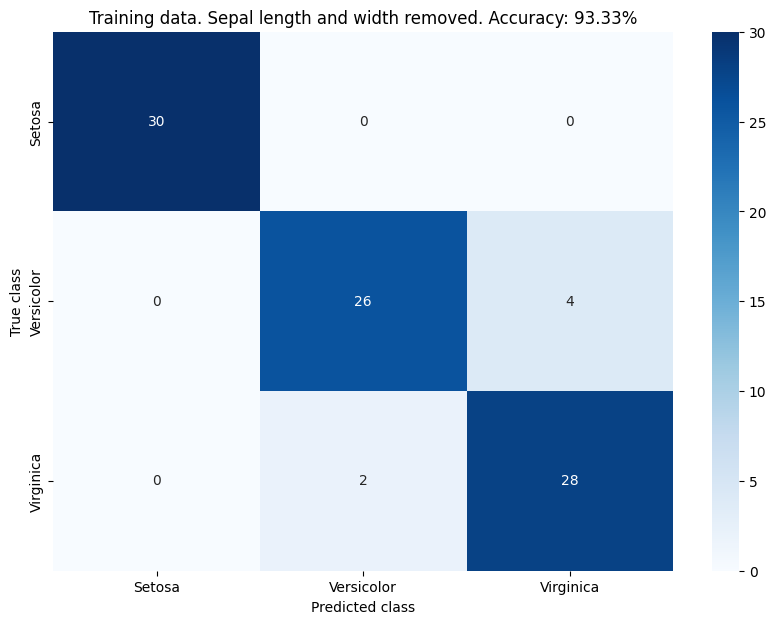


Test data
Accuracy: 93.33%
Setosa precision: 100.00%, recall: 100.00%
Versicolor precision: 90.00%, recall: 90.00%
Virginica precision: 90.00%, recall: 90.00%


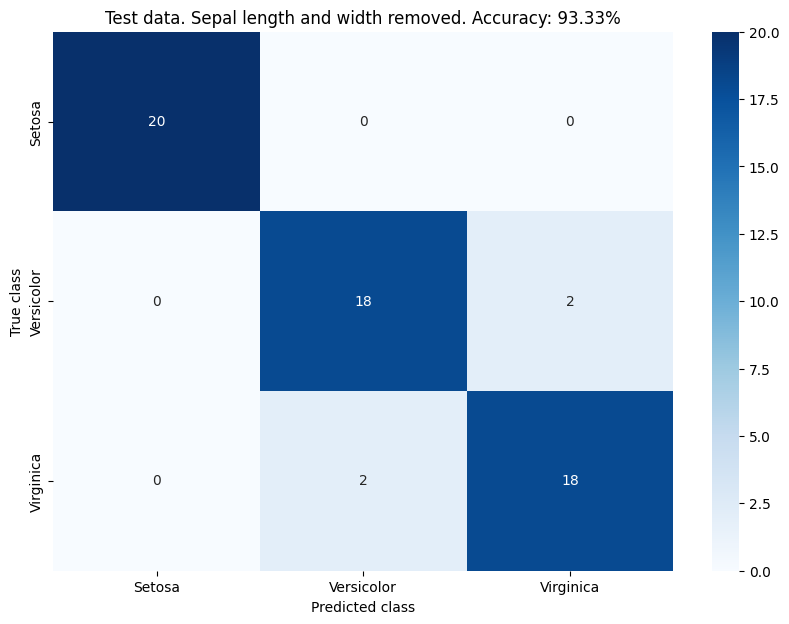

In [11]:
# Task 1.2a. Remove sepal width and length
feat_remove_index = np.where((name_features == "Sepal width") | (name_features == "Sepal length"))[0]
train_test_sequence("Sepal length and width removed", feat_remove=feat_remove_index)

### Remove sepal width, sepal length and petal length

Shape of raw train data (90, 4)
Shape of raw test data (60, 4)
Shape of extended train data (90, 5)
Shape of extended test data (60, 5)
Shape of train data after removing features (90, 2)
Shape of test data after removing features(60, 2)
Final values on train set: MSE: 022.66 |∇MSE|: 0.3336

Training data
Accuracy: 87.78%
Setosa precision: 100.00%, recall: 100.00%
Versicolor precision: 100.00%, recall: 63.33%
Virginica precision: 73.17%, recall: 100.00%


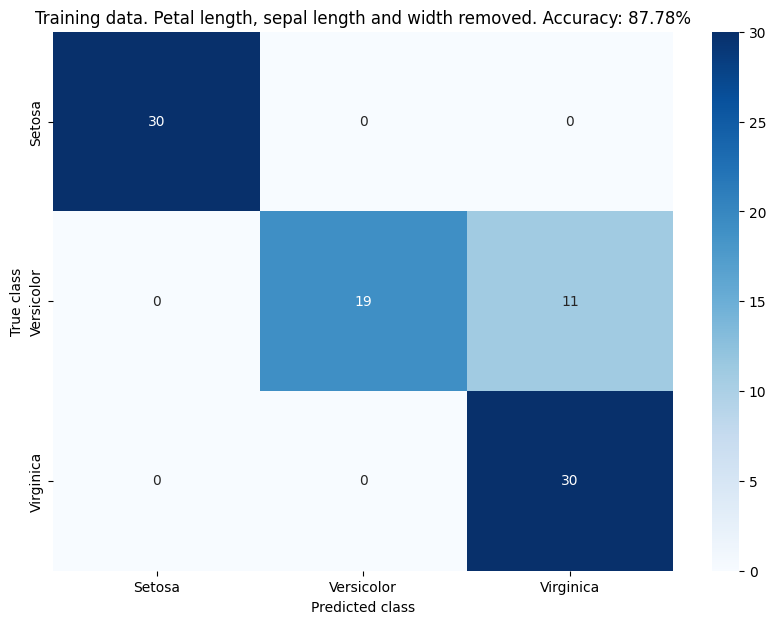


Test data
Accuracy: 91.67%
Setosa precision: 100.00%, recall: 100.00%
Versicolor precision: 94.12%, recall: 80.00%
Virginica precision: 82.61%, recall: 95.00%


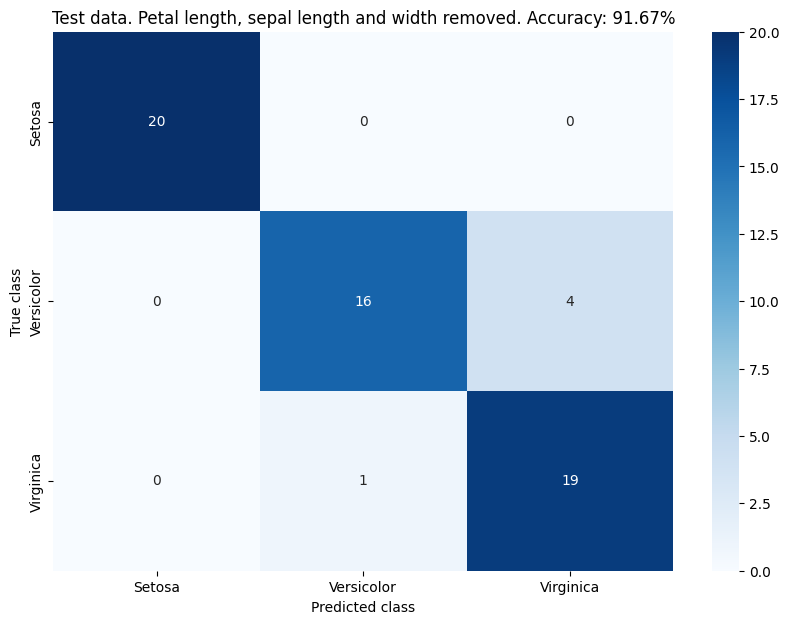

In [12]:
# Task 1.2a, Remove petal length, sepal width and length
feat_remove_index = np.where((name_features == "Sepal width") | (name_features == "Sepal length") | (name_features == "Petal length"))[0]
train_test_sequence("Petal length, sepal length and width removed", feat_remove=feat_remove_index)

### Remove sepal with, sepal length and petal width

Shape of raw train data (90, 4)
Shape of raw test data (60, 4)
Shape of extended train data (90, 5)
Shape of extended test data (60, 5)
Shape of train data after removing features (90, 2)
Shape of test data after removing features(60, 2)
Final values on train set: MSE: 023.09 |∇MSE|: 0.3264

Training data
Accuracy: 82.22%
Setosa precision: 100.00%, recall: 100.00%
Versicolor precision: 100.00%, recall: 46.67%
Virginica precision: 65.22%, recall: 100.00%


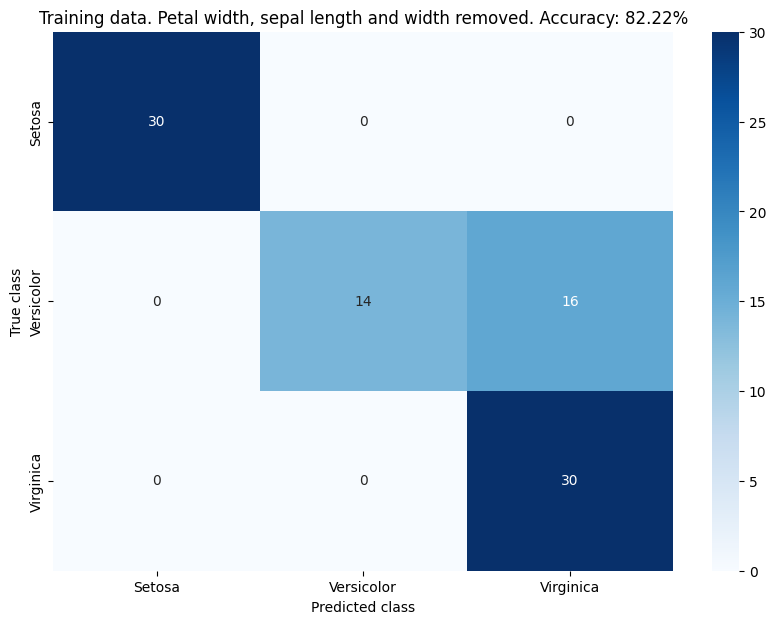


Test data
Accuracy: 90.00%
Setosa precision: 95.24%, recall: 100.00%
Versicolor precision: 100.00%, recall: 70.00%
Virginica precision: 80.00%, recall: 100.00%


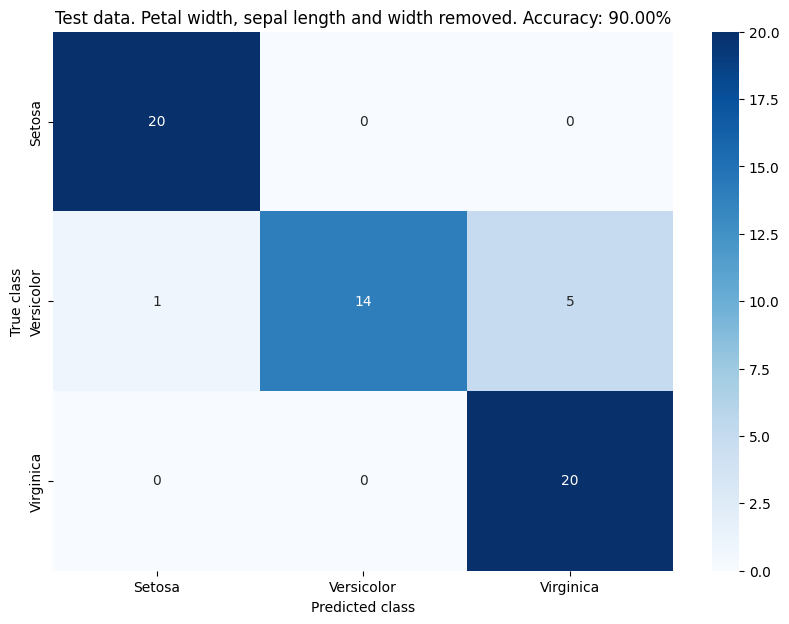

In [13]:
# Task 1.2a, Remove petal width, sepal width and length
feat_remove_index = np.where((name_features == "Sepal width") | (name_features == "Sepal length") | (name_features == "Petal width"))[0]
train_test_sequence("Petal width, sepal length and width removed", feat_remove=feat_remove_index)

### Plot feature against feature

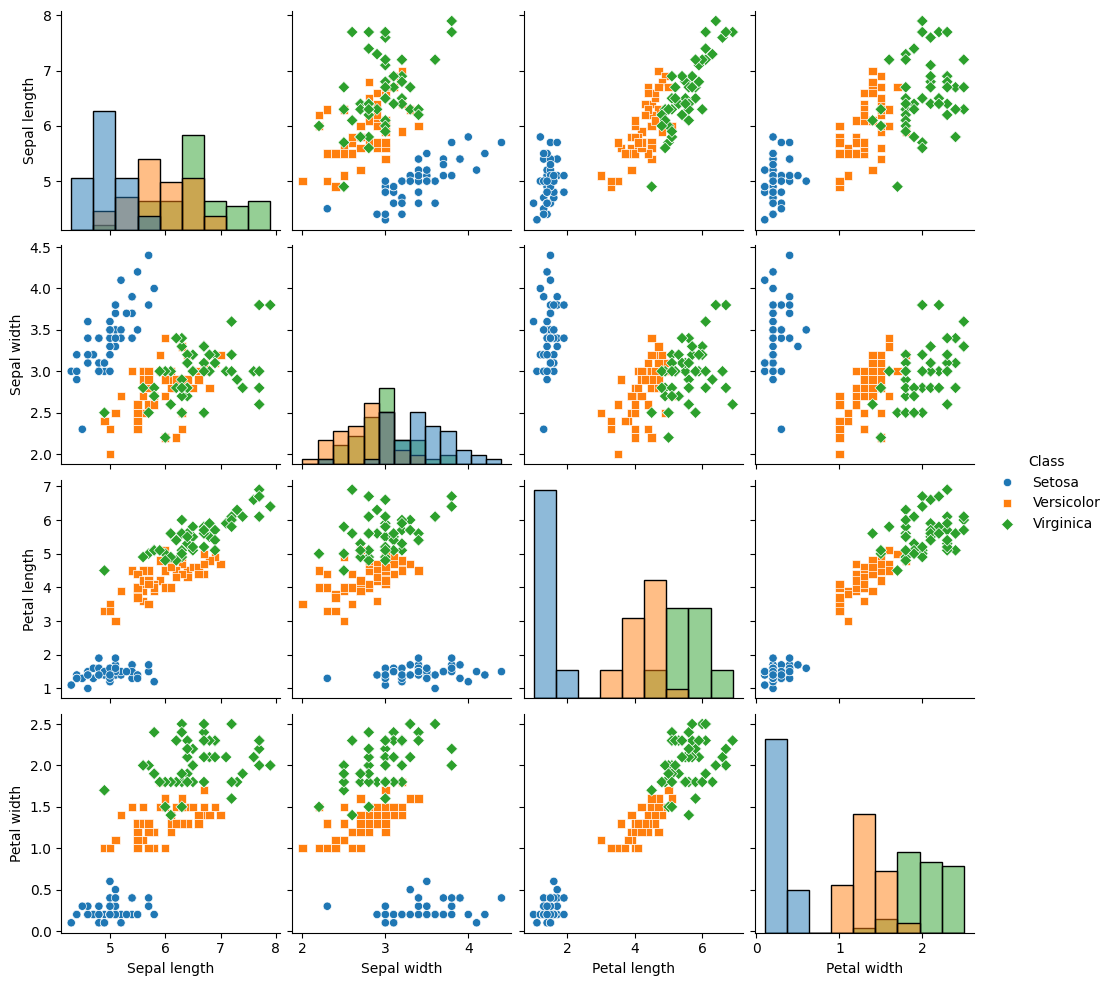

In [14]:
# Not part of the task
import pandas as pd

data = load_data()
T, _ = generate_labels(50)
class_labels = name_classes[np.argmax(T, axis=1)]

data_with_class = np.column_stack((data.reshape((150, 4)), class_labels))

df = pd.DataFrame(data.reshape((150, 4)), columns=name_features, dtype=float)
df["Class"] = class_labels
# Pairplot with classes marked
sn.pairplot(df, hue="Class", diag_kind="hist", markers=["o", "s", "D"])

plt.show()